In [4]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools
import cv2
from PIL import Image

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from skimage import io
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

In [4]:
df = pd.read_csv('kaggleMusicMoodFinal.csv')

In [5]:
spotify_df = df.copy()

In [6]:
spotify_df.shape

(156410, 27)

In [7]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [8]:
ohe_cols = 'popularity'

In [9]:
# create 5 point buckets for popularity 
spotify_df['bucket_popularity'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [10]:
spotify_df['consolidates_genre_lists_upd'] = spotify_df['consolidates_genre_lists'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [11]:
spotify_df.head()

,Unnamed: 0,Unnamed: 0.1,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,artists_upd_v1,artists_upd_v2,artists_upd,artists_song,consolidates_genre_lists,Mood,bucket_popularity,consolidates_genre_lists_upd
0,0,0,0.177,1989,0.568,['조정현'],0.447,237688,0.2150,0,2ghebdwe2pNXT4eL34T7pW,0.000001,10,0.0649,-16.478,1,그아픔까지사랑한거야,31,1989-06-15,0.0272,71.979,['조정현'],[],['조정현'],조정현그아픔까지사랑한거야,['classic_korean_pop'],Sad,6,[classic_korean_pop]
1,1,1,0.352,1992,0.381,['黑豹'],0.353,316160,0.6860,0,3KIuCzckjdeeVuswPo20mC,0.000000,11,0.0568,-9.103,1,DON'T BREAK MY HEART,35,1992-12-22,0.0395,200.341,['黑豹'],[],['黑豹'],黑豹DON'T BREAK MY HEART,"['chinese_indie', 'chinese_indie_rock']",Sad,7,"[chinese_indie, chinese_indie_rock]"
2,2,2,0.458,1963,0.987,['黃國隆'],0.241,193480,0.0437,0,4prhqrLXYMjHJ6vpRAlasx,0.000453,5,0.2650,-24.571,1,藝旦調,23,1963-05-28,0.0443,85.936,['黃國隆'],[],['黃國隆'],黃國隆藝旦調,[],Sad,4,[]
3,3,3,0.796,1963,0.852,"['黃國隆', '王秋玉']",0.711,145720,0.1110,0,5xFXTvnEe03SyvFpo6pEaE,0.000000,2,0.0695,-20.741,0,草螟弄雞公,23,1963-05-28,0.0697,124.273,"['黃國隆', '王秋玉']",[],"['黃國隆', '王秋玉']",黃國隆草螟弄雞公,[],Sad,4,[]
4,4,4,0.704,1963,0.771,['黃國隆'],0.610,208760,0.1750,0,6Pqs2suXEqCGx7Lxg5dlrB,0.000000,7,0.0309,-20.232,1,思想起,23,1963-05-28,0.0419,124.662,['黃國隆'],[],['黃國隆'],黃國隆思想起,[],Sad,4,[]


In [12]:
#simple function to create OHE features
#this gets passed later on
def One_Hot_Encode_Prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df



#function to build entire feature set
def Feature_Set_Using_TDiDF(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists_upd'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = One_Hot_Encode_Prep(df, 'explicit','exp')    
    year_ohe = One_Hot_Encode_Prep(df, 'year','year') * 0.5
    popularity_ohe = One_Hot_Encode_Prep(df, 'bucket_popularity','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final


def Get_Spotify_Playlist_DataFrame(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name
    
    #print(len(sp.playlist(id_dic[playlist_name])['tracks']['items']))

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    #playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist




def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()
    
    
    

def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas data00frame): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        playlist_features_not_in_dataframe (pandas dataframe): 
    """
    
    playlist_features_in_dataframe = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    playlist_features_in_dataframe = playlist_features_in_dataframe.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    playlist_features_not_in_dataframe = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = playlist_featu00000000000r100000000000000000000000000es_in_dataframe.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), playlist_features_not_in_dataframe





def Recommend_Playlist(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_40: Top 40 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_40 = non_playlist_df.sort_values('sim',ascending = False).head(40)
    non_playlist_df_top_40['url'] = non_playlist_df_top_40['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_40



In [14]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [15]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [16]:
token = util.prompt_for_user_token(scope, client_id=client_id, client_secret=client_secret, redirect_uri='http://localhost:8400/')

In [17]:
sp = spotipy.Spotify(auth=token)

In [18]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][0]['url']

In [19]:
id_name

{'Mixed': '2UL11PFnuIWv69TsyTwdwt', 'EDM': '43KYp7yRMBTMIPFP358dqH'}

In [20]:
def ChooseDataset(x):
    if x == "Disgust":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Calm'])]
    if x == "Angry":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Calm'])]
    if x == "Fear":
        return spotify_df[spotify_df['Mood'].isin(['Happy', 'Calm'])]
    if x == "Happy":
        return spotify_df[spotify_df['Mood'].isin(['Sad', 'Happy', 'Calm'])]
    if x == "Sad":
        return spotify_df[spotify_df['Mood'].isin(['Sad', 'Happy', 'Calm'])]
    if x == "Surprise":
        return spotify_df[spotify_df['Mood'].isin(['Energetic', 'Happy', 'Sad'])]
    return spotify_df

In [21]:
def Recommend_Top40(x):
    #..............................
    #.............................
    #............................
    
    O_df = ChooseDataset(x)
    
    # Feature Engineering from main dataframe
    complete_feature_set = Feature_Set_Using_TDiDF(O_df, float_cols=float_cols)#.mean(axis = 0)
    
    # collecting spotify user playlist dataframe
    one_playlist_from_spotify = Get_Spotify_Playlist_DataFrame('EDM', id_name, O_df)
    
    # linear vector for recommendation
    features_in_the_playlist, features_not_in_the_playlist = generate_playlist_feature(complete_feature_set, one_playlist_from_spotify, 1.09)
    
    
    # Recommended Songs store here
    top40_recommendation = Recommend_Playlist(spotify_df, features_in_the_playlist, features_not_in_the_playlist)
    
    
    visualize_songs(top40_recommendation)
    
    
    

In [8]:
from tensorflow.keras.models import load_model

model = load_model('MoodDetector.h5', compile = True)

OSError: SavedModel file does not exist at: moodDetection.h5\{saved_model.pbtxt|saved_model.pb}

In [5]:
def moodNamePrintFromLabel(n):
    if n == 0: result = "Angry"
    elif n == 1: result = "Disgust"
    elif n == 2: result = "Fear"
    elif n == 3: result = "Happy"
    elif n == 4: result = "Sad"
    elif n == 5: result = "Surprise"
    elif n == 6: result = "Neutral"
        
    return result

def imageToMoodDetection(img_path):

    img = cv2.imread(img_path)

    Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_casecade.detectMultiScale(Gray_img, 1.3, 3)

    for (x,y,w,h) in faces:
      pxl_lst = []
      for i in range(y, y+h):
        lst = []
        for j in range(x, x+w):
          lst.append(Gray_img[i][j])
        pxl_lst.append(lst)
      single_face = np.array(pxl_lst)
      single_face = np.reshape(single_face,(h,w,))

      resized_img = cv2.resize(single_face, (48,48), interpolation = cv2.INTER_AREA)
      
      resized_img = np.reshape(resized_img,(1,48,48,1))/255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))

In [6]:
Image_path = ''

# Recommended songs for 'EDM' Playlist for Neutral Mood

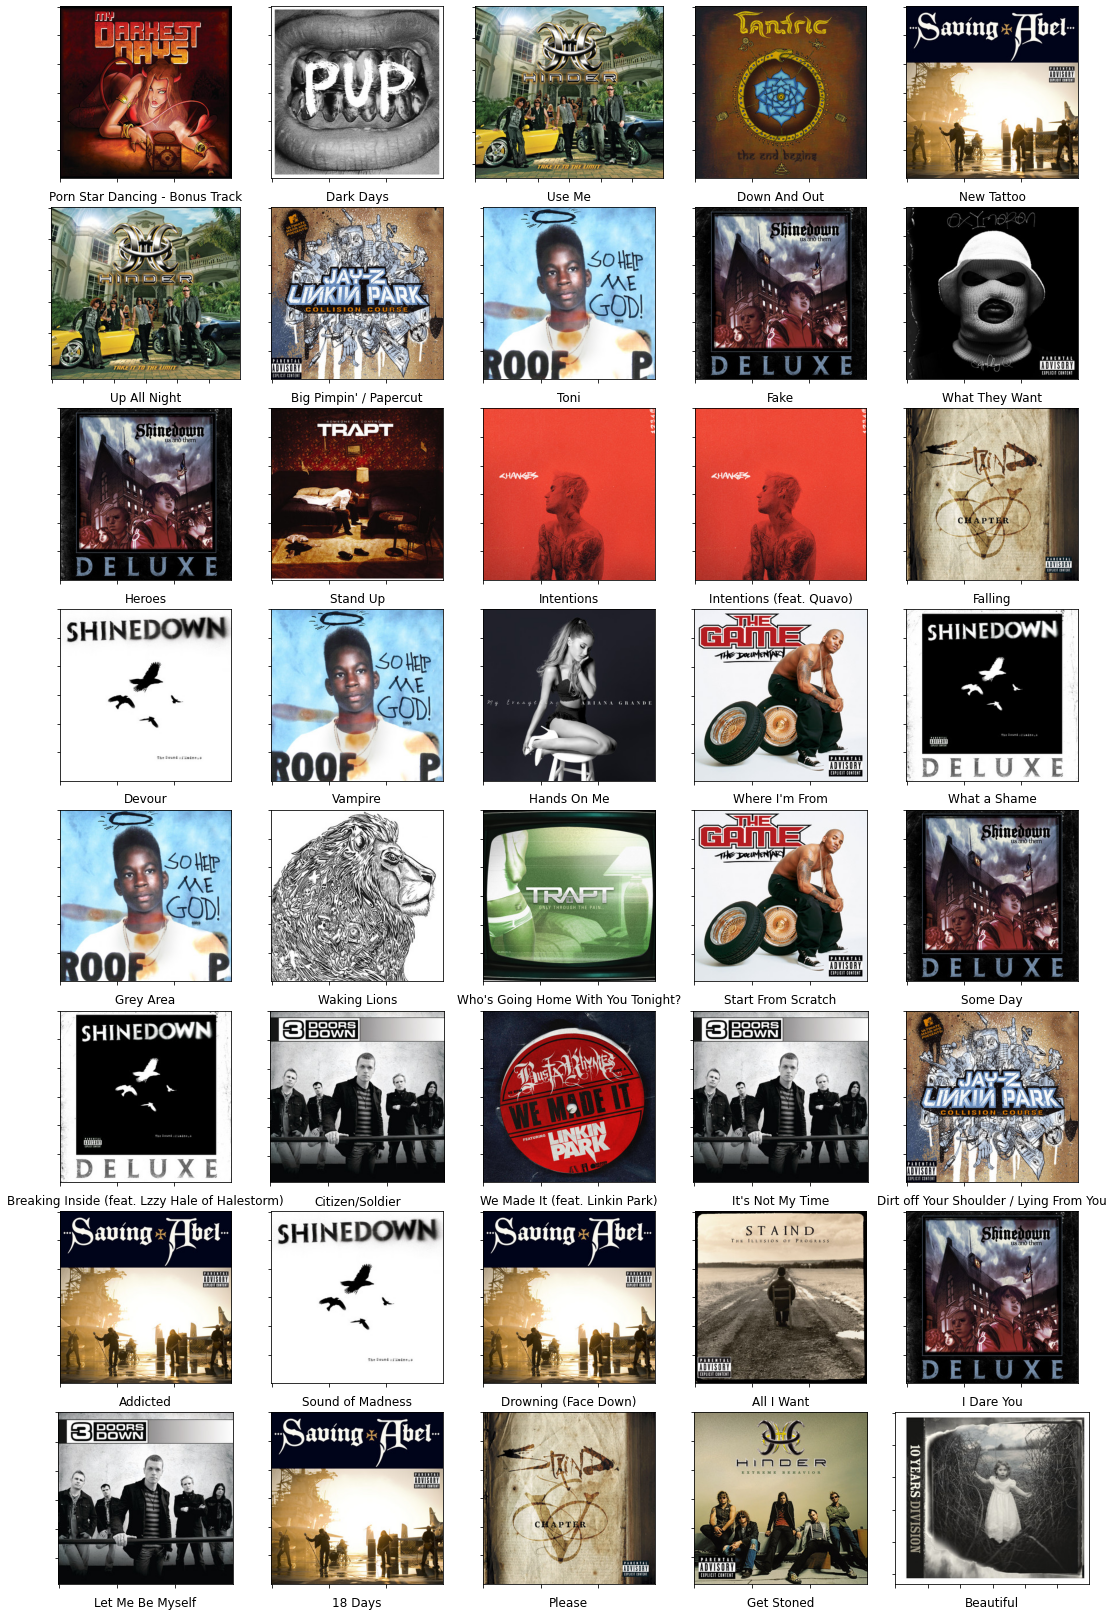

In [22]:
Recommend_Top40(imageToMoodDetection(Image_path))